# 2021-09-22 Newton linearization

## Last time

* Intro to rootfinding and Newton's method
* Bratu problem

## Today
* p-Laplacian
* algorithmic differentiation for matrix assembly
* principled by-hand differentiation

In [1]:
using Plots
using LinearAlgebra
using SparseArrays

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

fdstencil (generic function with 1 method)

# Newton for systems of equations

Let $\mathbf u \in \mathbb R^n$ and consider the function $\mathbf f(\mathbf u) \in \mathbb R^n$. Then
$$ \mathbf f(\mathbf u) = \mathbf f(\mathbf u_0) + \underbrace{\mathbf f'(\mathbf u_0)}_{n\times n} \underbrace{\mathbf \delta u}_{n\times 1} + \frac 1 2 \underbrace{\mathbf f''(\mathbf u_0)}_{n\times n \times n} {(\delta \mathbf u)^2}_{n\times n} + O(|\delta\mathbf u|^3).$$

We drop all but the first two terms and name the Jacobian matrix $J(\mathbf u) = \mathbf f'(\mathbf u)$,
$$ \mathbf f(\mathbf u) \approx \mathbf f(\mathbf u_0) + J \delta \mathbf u .$$
Solving the right hand side equal to zero yields
\begin{align}
J \delta \mathbf u &= -\mathbf f(\mathbf u_k) \\
\mathbf u_{k+1} &= \mathbf u_k + \delta \mathbf u
\end{align}

# Newton in code


In [60]:
function newton(residual, jacobian, u0; maxits=20)
    u = u0
    uhist = [copy(u)]
    normhist = []
    for k in 1:maxits
        f = residual(u)
        push!(normhist, norm(f))
        J = jacobian(u)
        delta_u = - J \ f
        u += delta_u
        push!(uhist, copy(u))
    end
    uhist, normhist
end

newton (generic function with 1 method)

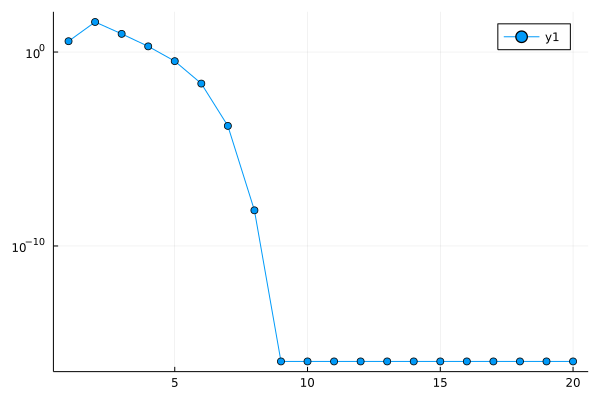

In [61]:
function residual(u)
    x, y = u
    [x^2 + y^2 - 1, x^2 - y]
end
function jacobian(u)
    x, y = u
    [2x 2y; 2x -1]
end

uhist, normhist = newton(residual, jacobian, [0.1, 2])
plot(normhist, marker=:auto, yscale=:log10)

# Plotting the trajectory

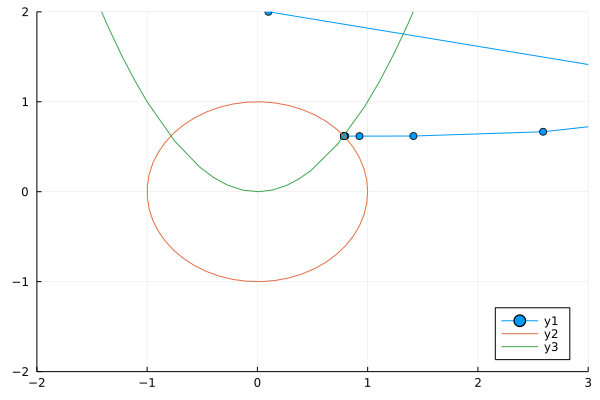

In [62]:
xy = hcat(uhist...)
plot(xy[1,:], xy[2,:], marker=:auto)
circle = exp.(1im*LinRange(0, 2*pi, 50))
plot!(real(circle), imag(circle))
plot!(x -> x^2, xlims=(-2, 3), ylims=(-2, 2), axes=:equal, legend=:bottomright)

# Bratu problem

$$-(u_x)_x - \lambda e^{u}= 0$$

In [63]:
function bratu_f(u; lambda=.5)
    n = length(u)
    h = 2 / (n - 1)
    weights = -fdstencil([-h, 0, h], 0, 2)
    u = copy(u)
    f = copy(u)
    u[[1, n]] = [0, 1]
    f[n] -= 1
    for i in 2:n-1
        f[i] = weights * u[i-1:i+1] - lambda * exp(u[i])
    end
    f
end

bratu_f (generic function with 1 method)

In [64]:
function bratu_J(u; lambda=.5)
    n = length(u)
    h = 2 / (n - 1)
    weights = -fdstencil([-h, 0, h], 0, 2)
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    for i in 2:n-1
        append!(rows, [i,i,i])
        append!(cols, i-1:i+1)
        append!(vals, weights + [0 -lambda*exp(u[i]) 0])
    end
    sparse(rows, cols, vals)
end

bratu_J (generic function with 1 method)

# Solving Bratu

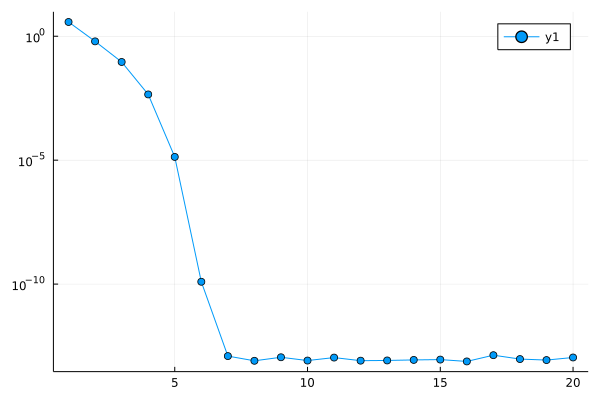

In [65]:
n = 20
x = collect(LinRange(-1., 1, n))
u0 = (1 .+ x) ./ 2
uhist, normhist = newton(bratu_f, bratu_J, u0);

plot(normhist, marker=:auto, yscale=:log10)

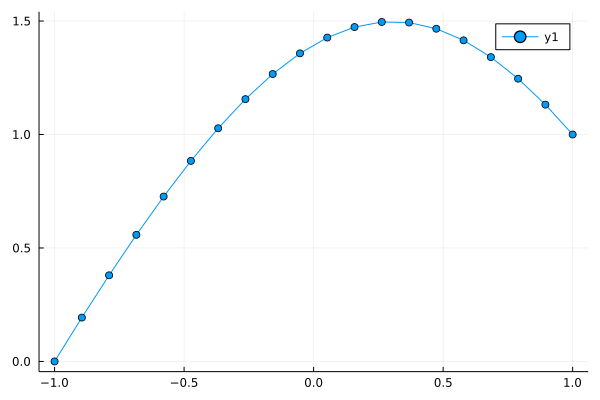

In [66]:
plot(x, uhist[end], marker=:auto)

# $p$-Laplacian

$$ -(|u_x|^{p-2} u_x)_x = 0 $$

In [74]:
plaplace_p = 1.5
plaplace_forcing = 0.
function plaplace_f(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    f = copy(u)
    u[[1, n]] = [0, 1]
    f[n] -= 1
    for i in 2:n-1
        u_xstag = diff(u[i-1:i+1]) / h
        kappa_stag = abs.(u_xstag) .^ (plaplace_p - 2)
        f[i] = [1/h, -1/h]' *
            (kappa_stag .* u_xstag) - plaplace_forcing
    end
    f
end

plaplace_f (generic function with 1 method)

In [75]:
function plaplace_J(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    u[[1, n]] = [0, 1]
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    for i in 2:n-1
        js = i-1:i+1
        u_xstag = diff(u[js]) / h
        kappa_stag = abs.(u_xstag) .^ (plaplace_p - 2)
        fi = [h, -h]' * (kappa_stag .* u_xstag)
        fi_ujs = [-kappa_stag[1]/h^2,
                  sum(kappa_stag)/h^2,
                  -kappa_stag[2]/h^2]
        mask = 1 .< js .< n
        append!(rows, [i,i,i][mask])
        append!(cols, js[mask])
        append!(vals, fi_ujs[mask])
    end
    sparse(rows, cols, vals)
end

plaplace_J (generic function with 1 method)

# Try solving

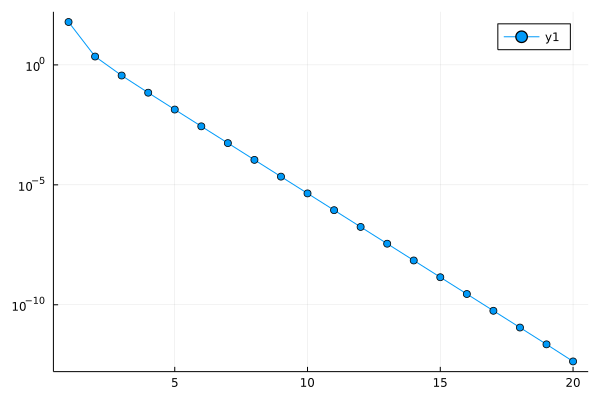

In [114]:
n = 20
x = collect(LinRange(-1., 1, n))
u0 = (1 .+ x)

plaplace_p = 1.8
plaplace_forcing = 1
uhist, normhist = newton(plaplace_f, plaplace_J, u0; maxits=20);
plot(normhist, marker=:auto, yscale=:log10)

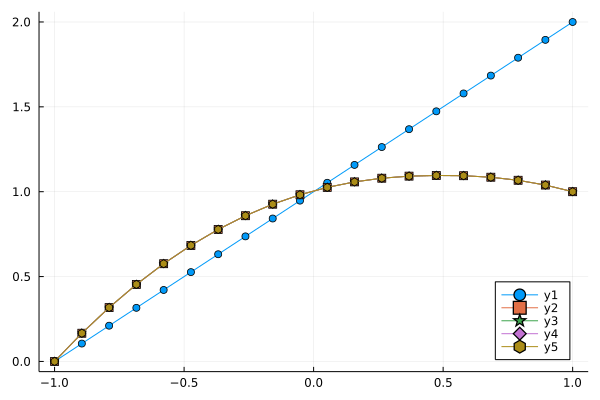

In [115]:
plot(x, uhist[1:5:end], marker=:auto, legend=:bottomright)

## What's wrong?

# Using Zygote to differentiate

In [102]:
using Zygote

gradient(x -> x^2, 3)

(6,)

In [103]:
function plaplace_fpoint(u, h)
    u_xstag = diff(u) / h
    kappa_stag = abs.(u_xstag) .^ (plaplace_p - 2)
    [1/h, -1/h]' * (kappa_stag .* u_xstag)
end

gradient(u -> plaplace_fpoint(u, .1), [0., .7, 1.])

([-1.7354486343415298, 5.455859214454552, -3.7204105801130227],)

# p-Laplacian with Zygote

In [104]:
function plaplace_fzygote(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    f = copy(u)
    u[[1, n]] = [0, 1]
    f[n] -= 1
    for i in 2:n-1
        f[i] = plaplace_fpoint(u[i-1:i+1], h) - plaplace_forcing
    end
    f
end

plaplace_fzygote (generic function with 1 method)

In [105]:
function plaplace_Jzygote(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    u[[1, n]] = [0, 1]
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    for i in 2:n-1
        js = i-1:i+1
        fi_ujs = gradient(ujs -> plaplace_fpoint(ujs, h), u[js])[1]
        mask = 1 .< js .< n
        append!(rows, [i,i,i][mask])
        append!(cols, js[mask])
        append!(vals, fi_ujs[mask])
    end
    sparse(rows, cols, vals)
end

plaplace_Jzygote (generic function with 1 method)

# Test it out

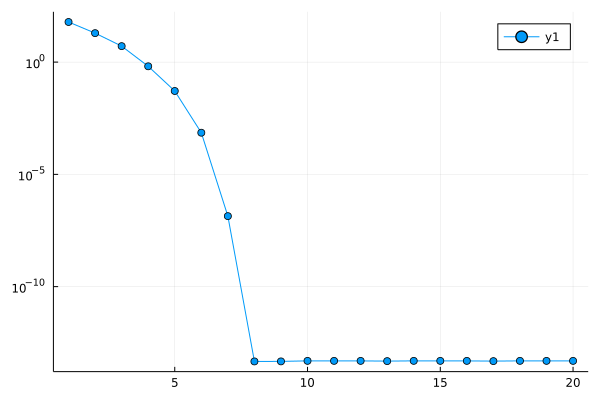

In [125]:
plaplace_p = 1.8
plaplace_forcing = 1
uhist, normhist = newton(plaplace_fzygote, plaplace_Jzygote, u0; maxits=20);
plot(normhist, marker=:auto, yscale=:log10)

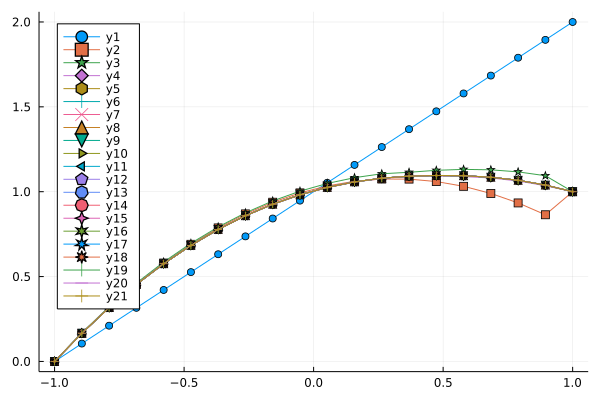

In [126]:
plot(x, uhist, marker=:auto, legend=:topleft)

* Can you fix the `plaplace_J` to differentiate correctly (analytically)?
* What is causing Newton to diverge?
* How might we fix or work around it?

# A model problem

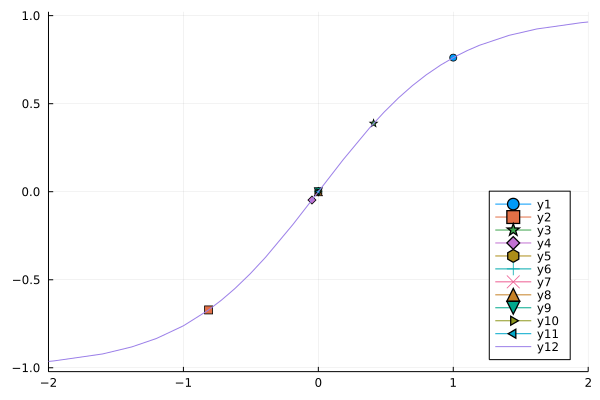

In [140]:
k = 1
fk(x) = tanh.(k*x)
Jk(x) = reshape(k / cosh.(k*x).^2, 1, 1)
xhist, normhist = newton(fk, Jk, [1.], maxits=10)
plot(xhist, fk.(xhist), marker=:auto, legend=:bottomright)
plot!(fk, xlims=(-2, 2))

# What about symbolic differentiation?

In [141]:
import Symbolics: Differential, expand_derivatives, @variables
@variables x
Dx = Differential(x)
y = tanh(k*x)
Dx(y)

Differential(x)(tanh(x))

In [142]:
expand_derivatives(Dx(y))

1 - (tanh(x)^2)

# Cool, what about products?

In [143]:
y = x
for _ in 1:2
    y = cos(y^pi) * log(y)
end
expand_derivatives(Dx(y))

((x^-1)*cos(x^π) - 3.141592653589793(x^2.141592653589793)*log(x)*sin(x^π))*(log(x)^-1)*(cos(x^π)^-1)*cos((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793)) - (3.141592653589793(x^-1)*(log(x)^2.141592653589793)*(cos(x^π)^3.141592653589793) - 9.869604401089358(x^2.141592653589793)*(log(x)^3.141592653589793)*(cos(x^π)^2.141592653589793)*sin(x^π))*sin((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793))*log(log(x)*cos(x^π))

* The size of these expressions can grow **exponentially**.

# Hand coding derivatives: it's all chain rule and associativity
$$ df = f'(x) dx $$

In [144]:
function f(x)
    y = x
    for _ in 1:2
        a = y^pi
        b = cos(a)
        c = log(y)
        y = b * c
    end
    y
end

f(1.9), gradient(f, 1.9)

(-1.5346823414986814, (-34.03241959914049,))

In [145]:
function df(x, dx)
    y = x
    dy = dx
    for _ in 1:2
        a = y^pi
        da = pi * y^(pi-1) * dy
        b = cos(a)
        db = -sin(a) * da
        c = log(y)
        dc = 1/y * dy
        y = b * c
        dy = db * c + b * dc
    end
    dy
end

df(1.9, 1)

-34.03241959914048

# We can go the other way

We can differentiate a composition $h(g(f(x)))$ as

\begin{align}
  \operatorname{d} h &= h' \operatorname{d} g \\
  \operatorname{d} g &= g' \operatorname{d} f \\
  \operatorname{d} f &= f' \operatorname{d} x.
\end{align}

What we've done above is called "forward mode", and amounts to placing the parentheses in the chain rule like

$$ \operatorname d h = \frac{dh}{dg} \left(\frac{dg}{df} \left(\frac{df}{dx} \operatorname d x \right) \right) .$$

The expression means the same thing if we rearrange the parentheses,

$$ \operatorname d h = \left( \left( \left( \frac{dh}{dg} \right) \frac{dg}{df} \right) \frac{df}{dx} \right) \operatorname d x $$

which we can compute with in reverse order via

$$ \underbrace{\bar x}_{\frac{dh}{dx}} = \underbrace{\bar g \frac{dg}{df}}_{\bar f} \frac{df}{dx} .$$

# A reverse mode example

$$ \underbrace{\bar x}_{\frac{dh}{dx}} = \underbrace{\bar g \frac{dg}{df}}_{\bar f} \frac{df}{dx} .$$

In [146]:
function g(x)
    a = x^pi
    b = cos(a)
    c = log(x)
    y = b * c
    y
end
(g(1.4), gradient(g, 1.4))

(-0.32484122107701546, (-1.2559761698835525,))

In [147]:
function gback(x, y_)
    a = x^pi
    b = cos(a)
    c = log(x)
    y = b * c
    # backward pass
    c_ = y_ * b 
    b_ = c * y_
    a_ = -sin(a) * b_
    x_ = 1/x * c_ + pi * x^(pi-1) * a_
    x_
end
gback(1.4, 1)

-1.2559761698835525

# Kinds of algorithmic differentation

* Source transformation: Fortran code in, Fortran code out
  * Duplicates compiler features, usually incomplete language coverage
  * Produces efficient code
* Operator overloading: C++ types
  * Hard to vectorize
  * Loops are effectively unrolled/inefficient
* Just-in-time compilation: tightly coupled with compiler
  * JIT lag
  * Needs dynamic language features (JAX) or tight integration with compiler (Zygote, Enzyme)
  * Some [sharp bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#control-flow)

# How does Zygote work?

In [150]:
h1(x) = x^3 + 3*x
h2(x) = ((x * x)  + 3) * x
@code_llvm h1(4.)

;  @ In[150]:1 within `h1'
define double @julia_h1_15841(double %0) {
top:
; ┌ @ intfuncs.jl:314 within `literal_pow'
; │┌ @ operators.jl:560 within `*' @ float.jl:332
    %1 = fmul double %0, %0
    %2 = fmul double %1, %0
; └└
; ┌ @ promotion.jl:322 within `*' @ float.jl:332
   %3 = fmul double %0, 3.000000e+00
; └
; ┌ @ float.jl:326 within `+'
   %4 = fadd double %3, %2
; └
  ret double %4
}


In [151]:
@code_llvm gradient(h1, 4.)

;  @ /home/jed/.julia/packages/Zygote/nsu1Y/src/compiler/interface.jl:74 within `gradient'
define [1 x double] @julia_gradient_15844(double %0) {
top:
;  @ /home/jed/.julia/packages/Zygote/nsu1Y/src/compiler/interface.jl:76 within `gradient'
; ┌ @ /home/jed/.julia/packages/Zygote/nsu1Y/src/compiler/interface.jl:41 within `#50'
; │┌ @ In[150]:1 within `Pullback'
; ││┌ @ /home/jed/.julia/packages/ZygoteRules/OjfTt/src/adjoint.jl:59 within `#1849#back'
; │││┌ @ /home/jed/.julia/packages/Zygote/nsu1Y/src/lib/number.jl:6 within `#249'
; ││││┌ @ intfuncs.jl:313 within `literal_pow'
; │││││┌ @ float.jl:332 within `*'
        %1 = fmul double %0, %0
; ││││└└
; ││││┌ @ promotion.jl:322 within `*' @ float.jl:332
       %2 = fmul double %1, 3.000000e+00
; │└└└└
; │┌ @ /home/jed/.julia/packages/Zygote/nsu1Y/src/lib/lib.jl:17 within `accum'
; ││┌ @ float.jl:326 within `+'
     %3 = fadd double %2, 3.000000e+00
; └└└
  %.fca.0.insert = insertvalue [1 x double] undef, double %3, 0
  ret [1 x double] 

# Forward or reverse?

It all depends on the shape.

$$ \operatorname d h = \frac{dh}{dg} \left(\frac{dg}{df} \left(\frac{df}{dx} \operatorname d x \right) \right) .$$

$$ \operatorname d h = \left( \left( \left( \frac{dh}{dg} \right) \frac{dg}{df} \right) \frac{df}{dx} \right) \operatorname d x $$

* One input, many outputs: use forward mode
  * "One input" can be looking in one direction
* Many inputs, one output: use reverse mode
  * Will need to traverse execution backwards ("tape")
  * Hierarchical checkpointing
* About square? Forward is usually a bit more efficient.